<a href="https://colab.research.google.com/github/jtwang1027/business_analysis/blob/master/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading packages and Ingesting data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import seaborn as sns

from keras.callbacks import EarlyStopping
import pandas as pd

from tensorflow.keras import layers

TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:

data1=pd.read_csv('/content/drive/My Drive/feb_2020-dataset.csv')

#data1=data1.iloc[:4450,] #rounds it out and makes it easier to create sequences

In [0]:
data1['full_date']=data1.Year.astype('str')+'-'+data1.Month.astype('str')+'-'+data1.date.astype('str')

In [0]:
temp=pd.to_datetime(data1.full_date) #this is just to coerce the unpadded month to datetime

In [0]:
data1.full_date=pd.to_datetime(temp.dt.strftime('%Y-%m-%d') + '-' +data1.Hour.astype('str'), format='%Y-%m-%d-%H') #recombine date with hour (time)

In [0]:
#set date to index
data1.full_date=pd.to_datetime(data1.full_date)
data1.set_index('full_date',inplace=True)
#drop month/date/year split columns
data1.drop(['Month','date','Year','Hour'],axis=1, inplace=True)

In [7]:
data1.head()

,Gross Sales,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
full_date,,,,,,,,
2019-01-03 11:00:00,8.78,0,0,0,0,1,0,0
2019-01-03 12:00:00,96.74,0,0,0,0,1,0,0
2019-01-03 13:00:00,48.41,0,0,0,0,1,0,0
2019-01-03 14:00:00,79.26,0,0,0,0,1,0,0
2019-01-03 15:00:00,73.65,0,0,0,0,1,0,0


In [8]:
#if we want to examine rows from 2019, we can use this partial string
data1.loc['2019'].sample(5)

,Gross Sales,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
full_date,,,,,,,,
2019-08-13 11:00:00,18.49,0,0,0,0,0,1,0
2019-07-22 12:00:00,118.99,0,1,0,0,0,0,0
2019-08-24 15:00:00,144.36,0,0,1,0,0,0,0
2019-05-06 23:00:00,14.64,0,1,0,0,0,0,0
2019-04-07 21:00:00,39.84,0,0,0,1,0,0,0


# Data visualization and summary

Text(0.5, 0, 'Date')

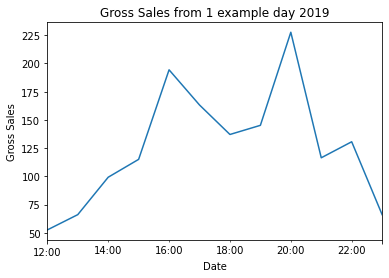

In [20]:
#the raw data can be difficult to interpret
data1.loc['2019-05-01','Gross Sales'].plot(linestyle='-')
plt.title('Gross Sales from 1 example day 2019')
plt.ylabel('Gross Sales')
plt.xlabel('Date')

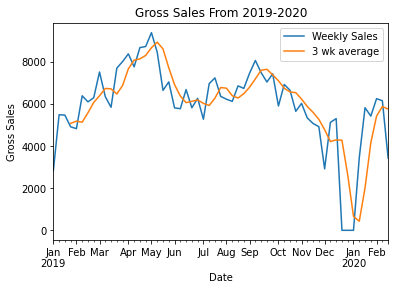

In [18]:
#it might be easier to see broad trends by downsampling into weeks
weekly=data1.resample('W').sum()
weekly.loc[:,'Gross Sales'].plot(linestyle='-') #weekly data
weekly['Gross Sales'].rolling(4,win_type='triang').mean().plot() #rolling mean

plt.title('Gross Sales From 2019-2020')
plt.ylabel('Gross Sales')
plt.xlabel('Date')

plt.legend(['Weekly Sales','4 wk average'])

From the data, we can see clear seasonality trends characterized by increased sales during the *Spring* months (March-May) with decreased sales during *Summer*, which is likely due to the college students going home. When the students return in the early fall, we see sales return upwards. As a result of the clear seasonality, we will test SARIMA (instead of ARIMA) in our forecasting model.

We also see missing data in Dec and Jan when the business was closed.

# Forecasting

Let's test different forecasting approaches. To generate a test set of data we need to build the model on past data and use it to predict the future. To prevent data leakage we will sklearn's *TimeSeriesSplit*

In [0]:
#from statsmodels.tsa.arima_model import SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [0]:
#forecast on daily data
daily=data1.resample('D').sum()
daily.asfreq(freq='D') #set frequency to days, will be helpful when we fit sarimax model
daily=daily[daily.index<'2019-12'] #use only 2019 up to Nov, exclude 2020

#setting X and y for fit
y=daily['Gross Sales'] # sales
X= daily.index #date

## ARIMA

In [0]:
tscv= TimeSeriesSplit(n_splits=10)
#print(tscv)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

mean squared erro:  [73044.94519977261, 91812.2771869567, 80072.59759640634, 148067.7400321824, 18164.496516616684, 90672.9307777848, 33212.040389193535, 110638.76651210594, 48889.833754915, 118621.67540654288]


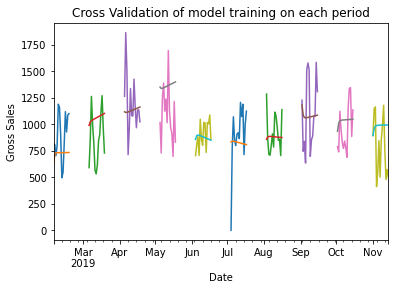

In [128]:
mse=[]
for train_index, test_index in tscv.split(X):
  '''train and test - index return row indices (not date indices)
  
  generate SARIMAX models for each and perform cross-validation, calculate MSE and generate visualizations '''
  #generate training and testing data
  #X_test = X[test_index]
  #x data is not needed, datetime index is embedded in y value already

  y_train, y_test = y[train_index], y[test_index]
  
  
  #trian model
  model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1,1,1,1))
  model_sarimax = model.fit(disp=False)

  #find MSE for the next n- days of predictions
  n= 14 # number of days to forecast out
  yhat=model_sarimax.forecast(n) #forecasting using sarimax model

  mse.append(mean_squared_error(yhat, y_test[:n]))

  y_test[:n].plot()
  yhat.plot()

plt.title('Cross Validation of model training on each period')
plt.ylabel('Gross Sales')
plt.xlabel('Date')
print("mean squared erro: ", mse)


Text(0.5, 0, 'Date')

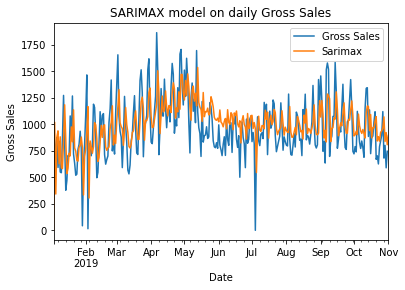

In [127]:
y[y.index<'2019-11'].plot()
model_sarimax.predict(start=y.index.min(),end='2019-11').plot()

plt.legend(['Gross Sales','Sarimax'])
plt.title('SARIMAX model on daily Gross Sales')
plt.ylabel('Gross Sales')
plt.xlabel('Date')

## LSTM

Each 'time step' should reflect some *real* time block, such as 1 working day or week. The store is typically open for 12hr per day, so We will drop data for days where there isn't a 12 hour open period.

In [0]:
num=data1.groupby(['Year','Month','date'])['Hour'].agg(['count'])
num.reset_index(inplace=True)
num.head()#count column shows how many hours we have data for in that day; #the mode is 12 hr
#alternatively we could do imputation instead of dropping the data

,Year,Month,date,count
0,2019,1,3,10
1,2019,1,4,8
2,2019,1,5,11
3,2019,1,6,9
4,2019,1,7,13


In [0]:
num=num[num['count']==12] #keep only dates where we have 12h of open time

In [0]:
data2=num.merge(data1, left_on=['Year', 'Month','date'], right_on=['Year', 'Month','date']) #one to many join

The new df (data2) is of the correct shape. For each date in num, there are 12 hours of data. The final df should have 12 x242= 2904

In [0]:
data2.shape

(2904, 13)

In [0]:
num.shape

(242, 4)

In [0]:
y=data2['Gross Sales'] 
X= data2.drop(['Gross Sales'],axis=1)
X=X.reindex(sorted(X.columns),axis=1) #put in alphabetical order
X.sort_values(['Year', 'Month','date','Hour'], ascending=[True]*4, inplace=True)

In [0]:
y=y[:2856] # keep first 2856/2904; to make it easier to sequence through weeks

In [0]:
# split into sample timesteps
samples = list()
length = 84 #length of each time step (or time sequence representing the 12 hours open each day x 7 days= 1 week)
#timesteps= int(y.shape[0]/length) #num

for i in range(0,len(y),length):
	# grab from i to i + length
  sample = y[i:i+length]
  samples.append(sample)

print (len(samples))

34


This 34 represents the 34 weeks (each day composed of a sequence of 12h x 7 days) that we're training/testing on.

In [0]:
#reformat data into array and add 3rd filler dimension needed for lstm model
data=np.array(samples)

data=data.reshape((len(samples), length,1)) #length is the timestep size
data.shape


(34, 84, 1)

In [0]:
seq_length=length # length of a sequence

model = tf.keras.Sequential()
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(seq_length, dropout=0.2, recurrent_dropout=0.2, input_shape=(1,84), return_sequences=True)) #input dim :# y columns
model.add(layers.Dense(seq_length))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor= EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#model.summary()

In [0]:
ntrain= int(0.8*len(data)) #number of rows to train on , 80-20 train-test split

xtrain=data[:ntrain]
xtest= data[ntrain:-1]

#use previous week to model upcoming week by creating offset
ytrain=data[1:ntrain+1]
ytest= data[ntrain+1:]

#check that the dimensions matchup
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(27, 84, 1)
(27, 84, 1)
(6, 84, 1)
(6, 84, 1)


In [0]:
xtrain=xtrain.reshape(xtrain.shape[0],1,xtrain.shape[1])
ytrain=ytrain.reshape(ytrain.shape[0],1,ytrain.shape[1])

xtest=xtest.reshape(xtest.shape[0],1,xtest.shape[1])
ytest=ytest.reshape(ytest.shape[0],1,ytest.shape[1])

#check that the dimensions matchup
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)


#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

(27, 1, 84)
(27, 1, 84)
(6, 1, 84)
(6, 1, 84)


In [0]:
epoch=100

history=model.fit(xtrain, ytrain, validation_data=(xtest, ytest),batch_size=1, callbacks=[monitor], verbose=0, epochs= epoch)

Epoch 00089: early stopping


In [0]:
total_epochs=len(history.history['loss'])


plt.plot(range(total_epochs), history.history['loss'])
plt.plot(range(total_epochs), history.history['val_loss'])
plt.legend(['train','test set MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [0]:
ypred=model.predict(xtest)
ypred_flat= [item for sublist in ypred for item in sublist]

ytest_flat= [item for sublist in ytest for item in sublist]
#len(ypred)

Text(0, 0.5, 'Gross Sales per hour')

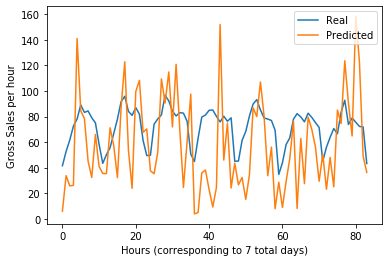

In [0]:
plt.plot(range(84), ypred_flat[1])
plt.plot(range(84), ytest_flat[1])
plt.legend(['Real','Predicted'])
plt.xlabel('Hours (corresponding to 7 total days)')
plt.ylabel('Gross Sales per hour')

#Conclusion
This model performance is comparable to the xgboost model in this case. It could be improved by adding additional factors. Or, the time sequence used to "look back" could be adjusted to capture different ranges of trends and information.